<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/GAN/GAN_Cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN (Generative Adversarial Network)


## Import and Config

In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 952kB 45.8MB/s 


In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

## Define Model

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

class Generator(nn.Module):
    def __init__(self, dim=256, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Generator, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(100, dim),
            nn.BatchNorm1d(dim),
            nn.LeakyReLU(),
            nn.Linear(dim, dim * 2),
            nn.BatchNorm1d(dim * 2),
            nn.LeakyReLU(),
            nn.Linear(dim * 2, dim * 4),
            nn.BatchNorm1d(dim * 4),
            nn.LeakyReLU(),
            nn.Linear(dim * 4, in_height * in_width * in_channel),
            nn.Tanh(),
            Reshape(in_channel, in_height, in_width)
        )
        
    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self, dim=256, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Discriminator, self).__init__()

        self.module = nn.Sequential(
            Flatten(),
            nn.Linear(in_height * in_width * in_channel, dim * 2),
            nn.LeakyReLU(),
            nn.Linear(dim * 2, dim),
            nn.LeakyReLU(),
            nn.Linear(dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.module(x)


# Dataset

In [5]:
class Cifar10Dataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [6]:
transforms_train = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [38]:
def show_sample(Xs, show_num=8, name="input"):
    Xs = Xs.detach().cpu().numpy().transpose(0, 2, 3, 1)
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(name)
        plt.axis('off')
        
    plt.show()

In [47]:
def train():
    train_models = []
    train_model_paths = []

    EPOCH = 400
        
    train_losses_d = []
    train_losses_g = []
        
    #---
    # datasert
    #---
    batch_size = 512

    train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
    train_Xs = train_ds.data.astype(np.float32)
    train_ys = np.array(train_ds.targets)

    dataset_train = Cifar10Dataset(train_Xs, train_ys, transforms=transforms_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)

    train_n = len(dataloader_train)

    #---
    # model
    #---
    gen = Generator().to(device)
    dis = Discriminator().to(device)

    criterion = nn.BCELoss()
    opt_d = torch.optim.Adam(dis.parameters(), lr=0.0002)
    opt_g = torch.optim.Adam(gen.parameters(), lr=0.0002)

    #---
    # epoch
    #---
    for epoch in range(EPOCH):
        gen.train()
        dis.train()
        
        tr_loss_d = 0
        tr_loss_g = 0
        total = 0
        
        #---
        # train
        #---
        train_time_start = time.time()
        
        for step, batch in enumerate(dataloader_train):
            opt_d.zero_grad()
            opt_g.zero_grad()

            xs = batch[0].to(device)

            _batch_size = len(xs)

            ones = torch.ones([_batch_size, 1]).to(device)
            zeros = torch.zeros([_batch_size, 1]).to(device)

            #---
            # update discriminator
            #---

            # real x
            y_real = dis(xs)
            loss_real = criterion(y_real, ones)

            # fake x
            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs)
            y_fake = dis(x_fake)
            loss_fake = criterion(y_fake, zeros)
            loss_d = loss_real + loss_fake

            loss_d.backward()
            opt_d.step()

            #---
            # update generator
            #--- 
            opt_d.zero_grad()
            opt_g.zero_grad()

            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs)
            y_fake = dis(x_fake)
            loss_g = criterion(y_fake, ones)
            loss_g.backward()
            opt_g.step()

            tr_loss_d += loss_d.item() / train_n
            tr_loss_g += loss_g.item() / train_n

        train_losses_d.append(tr_loss_d)
        train_losses_g.append(tr_loss_g)

        train_time_end = time.time()

        train_time_total = train_time_end - train_time_start
            
        print(f"epoch:{epoch + 1}/{EPOCH} [tra]loss-d:{tr_loss_d:.4f} loss-g:{tr_loss_g:.4f} [time]tra:{train_time_total:.2f}sec")

        if (epoch + 1) % 100 == 0:
            savename = f"model_epoch{epoch + 1}_{EPOCH}.pth"
            torch.save(gen.state_dict(), savename)
            print(f"model saved to >> {savename}")

        if (epoch + 1) % 50 == 0:
            show_sample(x_fake, name="output")

    #---
    # save model
    #---
    savename = f"model_epoch{EPOCH}.pth"
    torch.save(gen.state_dict(), savename)
    print(f"model saved to >> {savename}")
    print()
    
    train_models.append(gen)
    train_model_paths.append(savename)
    

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.grid()
    ax1.plot(train_losses_d, marker=".", markersize=6, color="red", label="train loss d")
    ax1.plot(train_losses_g, marker=".", markersize=6, color="blue", label="train loss g")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    ax1.set(xlabel="Epoch", ylabel="Loss")
    plt.show()

        
    return train_models, train_model_paths


Files already downloaded and verified
epoch:1/400 [tra]loss-d:0.4261 loss-g:4.5282 [time]tra:3.05sec
epoch:2/400 [tra]loss-d:0.1781 loss-g:6.2978 [time]tra:3.11sec
epoch:3/400 [tra]loss-d:0.0645 loss-g:20.1297 [time]tra:3.03sec
epoch:4/400 [tra]loss-d:0.0251 loss-g:26.9110 [time]tra:3.35sec
epoch:5/400 [tra]loss-d:0.0188 loss-g:25.8693 [time]tra:3.04sec
epoch:6/400 [tra]loss-d:0.0185 loss-g:24.2909 [time]tra:3.20sec
epoch:7/400 [tra]loss-d:0.1614 loss-g:26.0793 [time]tra:3.03sec
epoch:8/400 [tra]loss-d:0.1235 loss-g:25.9711 [time]tra:2.98sec
epoch:9/400 [tra]loss-d:0.1036 loss-g:12.4993 [time]tra:3.01sec
epoch:10/400 [tra]loss-d:0.0625 loss-g:11.7031 [time]tra:3.03sec
epoch:11/400 [tra]loss-d:0.0400 loss-g:11.2567 [time]tra:3.12sec
epoch:12/400 [tra]loss-d:0.1171 loss-g:24.0813 [time]tra:2.96sec
epoch:13/400 [tra]loss-d:0.0850 loss-g:20.6915 [time]tra:3.12sec
epoch:14/400 [tra]loss-d:0.0640 loss-g:10.5119 [time]tra:3.20sec
epoch:15/400 [tra]loss-d:0.0728 loss-g:8.7071 [time]tra:3.01sec

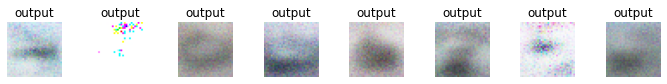

epoch:51/400 [tra]loss-d:0.1332 loss-g:6.3834 [time]tra:2.95sec
epoch:52/400 [tra]loss-d:0.1039 loss-g:6.6271 [time]tra:3.03sec
epoch:53/400 [tra]loss-d:0.1036 loss-g:7.2358 [time]tra:3.04sec
epoch:54/400 [tra]loss-d:0.0865 loss-g:7.0217 [time]tra:2.92sec
epoch:55/400 [tra]loss-d:0.0895 loss-g:6.9088 [time]tra:3.18sec
epoch:56/400 [tra]loss-d:0.0766 loss-g:6.6291 [time]tra:3.02sec
epoch:57/400 [tra]loss-d:0.0803 loss-g:6.8800 [time]tra:2.95sec
epoch:58/400 [tra]loss-d:0.0766 loss-g:6.9694 [time]tra:2.94sec
epoch:59/400 [tra]loss-d:0.0848 loss-g:6.9946 [time]tra:3.03sec
epoch:60/400 [tra]loss-d:0.0760 loss-g:6.5727 [time]tra:2.96sec
epoch:61/400 [tra]loss-d:0.0749 loss-g:6.9545 [time]tra:3.00sec
epoch:62/400 [tra]loss-d:0.0751 loss-g:7.4525 [time]tra:2.91sec
epoch:63/400 [tra]loss-d:0.0682 loss-g:6.9204 [time]tra:2.90sec
epoch:64/400 [tra]loss-d:0.0646 loss-g:7.0552 [time]tra:2.97sec
epoch:65/400 [tra]loss-d:0.0818 loss-g:7.4166 [time]tra:2.88sec
epoch:66/400 [tra]loss-d:0.0809 loss-g:6

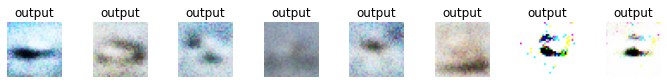

epoch:101/400 [tra]loss-d:0.1699 loss-g:5.3787 [time]tra:2.93sec
epoch:102/400 [tra]loss-d:0.1608 loss-g:4.7669 [time]tra:3.00sec
epoch:103/400 [tra]loss-d:0.1778 loss-g:4.8690 [time]tra:2.92sec
epoch:104/400 [tra]loss-d:0.1721 loss-g:4.7873 [time]tra:3.00sec
epoch:105/400 [tra]loss-d:0.1780 loss-g:4.9328 [time]tra:3.00sec
epoch:106/400 [tra]loss-d:0.1677 loss-g:4.7221 [time]tra:2.89sec
epoch:107/400 [tra]loss-d:0.1691 loss-g:5.0375 [time]tra:3.07sec
epoch:108/400 [tra]loss-d:0.1754 loss-g:5.0269 [time]tra:2.94sec
epoch:109/400 [tra]loss-d:0.1762 loss-g:5.1303 [time]tra:3.08sec
epoch:110/400 [tra]loss-d:0.1810 loss-g:5.0805 [time]tra:3.11sec
epoch:111/400 [tra]loss-d:0.1912 loss-g:4.8250 [time]tra:2.94sec
epoch:112/400 [tra]loss-d:0.1755 loss-g:4.7277 [time]tra:2.89sec
epoch:113/400 [tra]loss-d:0.1852 loss-g:4.8958 [time]tra:2.89sec
epoch:114/400 [tra]loss-d:0.1906 loss-g:4.4115 [time]tra:3.02sec
epoch:115/400 [tra]loss-d:0.2082 loss-g:4.6327 [time]tra:3.08sec
epoch:116/400 [tra]loss-d

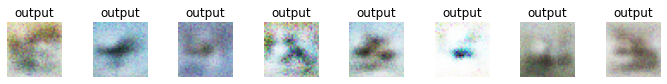

epoch:151/400 [tra]loss-d:0.2601 loss-g:3.8810 [time]tra:2.94sec
epoch:152/400 [tra]loss-d:0.2801 loss-g:3.7874 [time]tra:2.89sec
epoch:153/400 [tra]loss-d:0.2765 loss-g:3.7281 [time]tra:2.90sec
epoch:154/400 [tra]loss-d:0.2669 loss-g:3.8983 [time]tra:2.89sec
epoch:155/400 [tra]loss-d:0.2740 loss-g:4.0891 [time]tra:3.01sec
epoch:156/400 [tra]loss-d:0.2899 loss-g:3.8169 [time]tra:3.06sec
epoch:157/400 [tra]loss-d:0.3051 loss-g:4.0766 [time]tra:3.00sec
epoch:158/400 [tra]loss-d:0.2693 loss-g:4.1120 [time]tra:2.98sec
epoch:159/400 [tra]loss-d:0.2986 loss-g:3.9717 [time]tra:2.89sec
epoch:160/400 [tra]loss-d:0.2645 loss-g:3.6147 [time]tra:3.02sec
epoch:161/400 [tra]loss-d:0.2842 loss-g:4.0541 [time]tra:3.04sec
epoch:162/400 [tra]loss-d:0.2684 loss-g:4.0824 [time]tra:3.03sec
epoch:163/400 [tra]loss-d:0.2562 loss-g:4.4191 [time]tra:2.97sec
epoch:164/400 [tra]loss-d:0.2636 loss-g:4.0199 [time]tra:3.14sec
epoch:165/400 [tra]loss-d:0.2693 loss-g:4.1023 [time]tra:3.00sec
epoch:166/400 [tra]loss-d

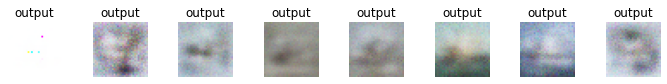

epoch:201/400 [tra]loss-d:0.2585 loss-g:4.1153 [time]tra:3.04sec
epoch:202/400 [tra]loss-d:0.2570 loss-g:3.9238 [time]tra:3.14sec
epoch:203/400 [tra]loss-d:0.2566 loss-g:3.9665 [time]tra:3.23sec
epoch:204/400 [tra]loss-d:0.2753 loss-g:4.0716 [time]tra:3.29sec
epoch:205/400 [tra]loss-d:0.2960 loss-g:3.8548 [time]tra:3.16sec
epoch:206/400 [tra]loss-d:0.2546 loss-g:3.8530 [time]tra:3.16sec
epoch:207/400 [tra]loss-d:0.2741 loss-g:3.8131 [time]tra:3.23sec
epoch:208/400 [tra]loss-d:0.2660 loss-g:3.7014 [time]tra:3.08sec
epoch:209/400 [tra]loss-d:0.2969 loss-g:3.8277 [time]tra:3.24sec
epoch:210/400 [tra]loss-d:0.2891 loss-g:3.7819 [time]tra:3.09sec
epoch:211/400 [tra]loss-d:0.3029 loss-g:3.6685 [time]tra:3.12sec
epoch:212/400 [tra]loss-d:0.2903 loss-g:3.6666 [time]tra:3.08sec
epoch:213/400 [tra]loss-d:0.2288 loss-g:4.0129 [time]tra:3.14sec
epoch:214/400 [tra]loss-d:0.2783 loss-g:4.2098 [time]tra:3.15sec
epoch:215/400 [tra]loss-d:0.2731 loss-g:3.7807 [time]tra:3.00sec
epoch:216/400 [tra]loss-d

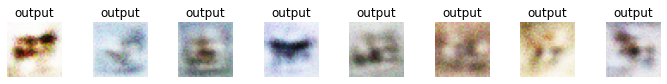

epoch:251/400 [tra]loss-d:0.2570 loss-g:3.9731 [time]tra:2.92sec
epoch:252/400 [tra]loss-d:0.2515 loss-g:3.9653 [time]tra:2.94sec
epoch:253/400 [tra]loss-d:0.2315 loss-g:4.2963 [time]tra:2.98sec
epoch:254/400 [tra]loss-d:0.2459 loss-g:4.0114 [time]tra:3.15sec
epoch:255/400 [tra]loss-d:0.2743 loss-g:3.7346 [time]tra:2.97sec
epoch:256/400 [tra]loss-d:0.2708 loss-g:3.9268 [time]tra:2.99sec
epoch:257/400 [tra]loss-d:0.2480 loss-g:4.0312 [time]tra:3.17sec
epoch:258/400 [tra]loss-d:0.2621 loss-g:4.1461 [time]tra:3.33sec
epoch:259/400 [tra]loss-d:0.2444 loss-g:3.9481 [time]tra:3.11sec
epoch:260/400 [tra]loss-d:0.2512 loss-g:3.8646 [time]tra:3.06sec
epoch:261/400 [tra]loss-d:0.2686 loss-g:3.9526 [time]tra:3.19sec
epoch:262/400 [tra]loss-d:0.2527 loss-g:3.9538 [time]tra:2.96sec
epoch:263/400 [tra]loss-d:0.2593 loss-g:4.0631 [time]tra:3.09sec
epoch:264/400 [tra]loss-d:0.2401 loss-g:4.0093 [time]tra:2.98sec
epoch:265/400 [tra]loss-d:0.2411 loss-g:4.0061 [time]tra:3.02sec
epoch:266/400 [tra]loss-d

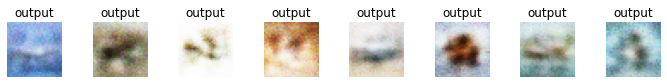

epoch:301/400 [tra]loss-d:0.2556 loss-g:3.9879 [time]tra:3.02sec
epoch:302/400 [tra]loss-d:0.2721 loss-g:4.0664 [time]tra:2.95sec
epoch:303/400 [tra]loss-d:0.2740 loss-g:3.8429 [time]tra:3.03sec
epoch:304/400 [tra]loss-d:0.2616 loss-g:4.0797 [time]tra:3.01sec
epoch:305/400 [tra]loss-d:0.2822 loss-g:3.9276 [time]tra:2.89sec
epoch:306/400 [tra]loss-d:0.2615 loss-g:3.8448 [time]tra:2.92sec
epoch:307/400 [tra]loss-d:0.2631 loss-g:3.9096 [time]tra:2.97sec
epoch:308/400 [tra]loss-d:0.2687 loss-g:3.9915 [time]tra:3.01sec
epoch:309/400 [tra]loss-d:0.2701 loss-g:3.9665 [time]tra:3.12sec
epoch:310/400 [tra]loss-d:0.2818 loss-g:3.9415 [time]tra:3.01sec
epoch:311/400 [tra]loss-d:0.2759 loss-g:3.6709 [time]tra:3.13sec
epoch:312/400 [tra]loss-d:0.2571 loss-g:3.8833 [time]tra:2.98sec
epoch:313/400 [tra]loss-d:0.2568 loss-g:4.0172 [time]tra:3.07sec
epoch:314/400 [tra]loss-d:0.2474 loss-g:4.2427 [time]tra:3.11sec
epoch:315/400 [tra]loss-d:0.2804 loss-g:3.9612 [time]tra:3.14sec
epoch:316/400 [tra]loss-d

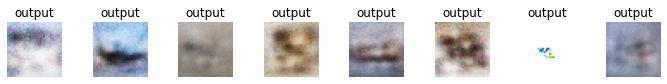

epoch:351/400 [tra]loss-d:0.2580 loss-g:4.0225 [time]tra:2.93sec
epoch:352/400 [tra]loss-d:0.2712 loss-g:3.9630 [time]tra:3.01sec
epoch:353/400 [tra]loss-d:0.2814 loss-g:3.9212 [time]tra:2.93sec
epoch:354/400 [tra]loss-d:0.2673 loss-g:3.9359 [time]tra:2.91sec
epoch:355/400 [tra]loss-d:0.2543 loss-g:4.0441 [time]tra:2.89sec
epoch:356/400 [tra]loss-d:0.2604 loss-g:4.0323 [time]tra:2.97sec
epoch:357/400 [tra]loss-d:0.2666 loss-g:3.9698 [time]tra:3.13sec
epoch:358/400 [tra]loss-d:0.2689 loss-g:3.8838 [time]tra:3.10sec
epoch:359/400 [tra]loss-d:0.2633 loss-g:4.1880 [time]tra:3.04sec
epoch:360/400 [tra]loss-d:0.2683 loss-g:4.1373 [time]tra:3.10sec
epoch:361/400 [tra]loss-d:0.2749 loss-g:4.0610 [time]tra:2.94sec
epoch:362/400 [tra]loss-d:0.2727 loss-g:3.9578 [time]tra:2.90sec
epoch:363/400 [tra]loss-d:0.2726 loss-g:3.9174 [time]tra:2.94sec
epoch:364/400 [tra]loss-d:0.2690 loss-g:3.9441 [time]tra:3.11sec
epoch:365/400 [tra]loss-d:0.2772 loss-g:3.9633 [time]tra:3.05sec
epoch:366/400 [tra]loss-d

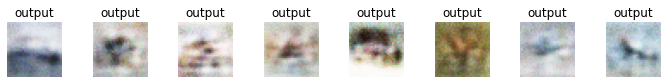

model saved to >> model_epoch400.pth



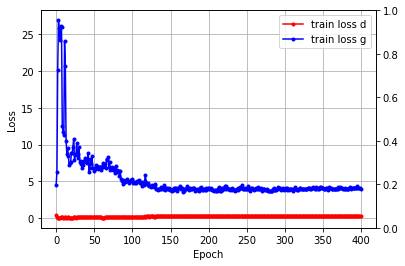

In [48]:
train_models, train_model_paths = train()

# Test

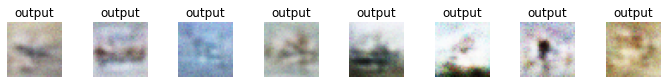

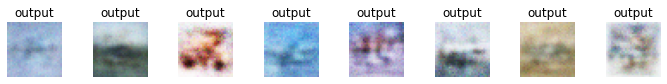

In [50]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    with torch.no_grad():
        model = train_models[0]

        for _ in range(2):
            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            xs = model(zs)
            show_sample(xs, name="output")

test(train_models)